# DBSCAN in practice

## First we import the required libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import sklearn.cluster as cluster
import time
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.30, 's' : 80, 'linewidths':0}

### This dataset is in npy format. This format is of Numpy and can be loaded via following command. For any analysis, we just need datapoints in their individual attributes form which are then passed to the respective algos and plots

In [2]:
data = np.load('clusterable_data.npy')

### You can find this dataset in the link below:
https://github.com/scikit-learn-contrib/hdbscan/raw/master/notebooks/clusterable_data.npy

### The npy data saved this dataset values as X values in index 0 and Y in index 1, so to use these, we do the following

In [4]:
data.T[0]

array([-0.12153499, -0.22093687,  0.1259037 , ...,  0.50243143,
        0.53822256, -0.08688887])

In [6]:
data.T[1]

array([-0.22876337, -0.25251088, -0.27314321, ..., -0.3002958 ,
        0.19412199, -0.2092721 ])

In [7]:
dataX=data.T[0].tolist()
dataY=data.T[1].tolist()

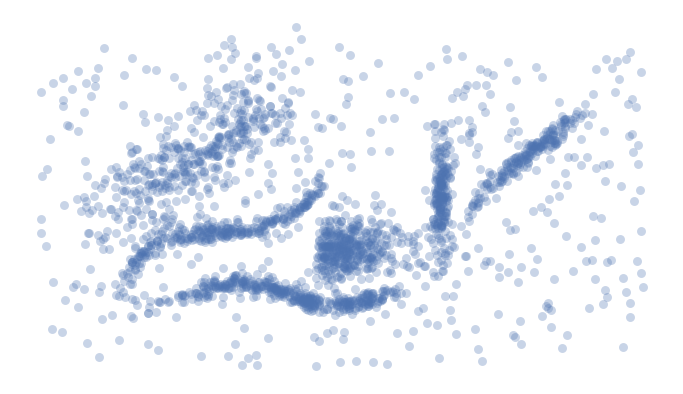

In [8]:
plt.figure(figsize=(12,7))
plt.scatter(dataX, dataY, c='b', **plot_kwds)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
frame.axis("off");

### This function below is a custom function, where we fit any algorithm we pass though and it fits the model and gives the respective output as well. Later on we just need to pass the clustering algorithm's name and it will give the respective results on its own

#### To understand more what's going on here, take a look at this article-
https://github.com/scikit-learn-contrib/hdbscan/blob/master/notebooks/Comparing%20Clustering%20Algorithms.ipynb

### Now below is the function that will create the final clusters

In [9]:
def plot_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    palette = sns.color_palette("bright", np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.figure(figsize=(12,7))
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    plt.text(0,0,'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14,transform=frame.transAxes)
    frame.axis("off")
    return labels;

### Now before we actually go on performing DBSCAN, what we need to set is the eps value, i.e. the radius within which DBSCAN tries to find the neighbours and the min number of points as well.

### Now how many minimum points we want in a cluster for it to be called a cluster is something that we have to define. So in current scenario, let's say we choose 6 points minimum should be there; but now the issue comes for the case to identify the radius of neighbourhood of any point. So one heuristic approach is to find the average distance of a point around it's k-neighbours and then plot them in ascending or descending order.

### Then looking at that k-distance graph, we can identify that distance beyond which the closeness to the neighbour starts increasing.

### So let's see how to do that

In [10]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import LocalOutlierFactor

### So to find the k nearest neightbours(in our case 6) we make use of Local Outlier Factor module in sklearn that we came across when we did LOF implementation in Python. Specifically it has a method which gives us output as distance of a point from it k neighbours and that's exactly what we need here to identify eps


In [11]:
neighbours=6
clf = LocalOutlierFactor(n_neighbors=neighbours, contamination=0.01)

### This KNN_distplot function creates a K-nearest neighbour distance plot of the points in an ascending order

### If working on R, this function is readily available; since it's not there in Python, I've created it here

In [14]:
def KNN_distplot(ob):
    
    data=[]
    for i in ob:
        data.append(i)
    
    data=np.array(data)
    clf.fit_predict(data)
    p=clf.kneighbors(data,n_neighbors=neighbours+1)
    
    dist=[]
    for i in p[0]:
        dist.append(np.mean(i[1:]))
        
    q=np.sort(dist)
    
    plt.figure(figsize=(10,8))
    plt.plot(q)
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(True)
    plt.yticks(np.arange(min(q), max(q), step=(max(q).round(2)-min(q))/20))
    plt.xticks([], [])
    plt.grid(True)
    plt.yticks(fontsize=12)
    plt.ylabel('Avg. Distance from k neighbours',fontsize=14)
    sns.despine()
    
    return data

### For it to work, we need to pass zipped X and Y values or more dimensional values, as can be the case that maybe our observations can have more than 2 and 3 dimensions. So that's why we pass a zipped form of these values

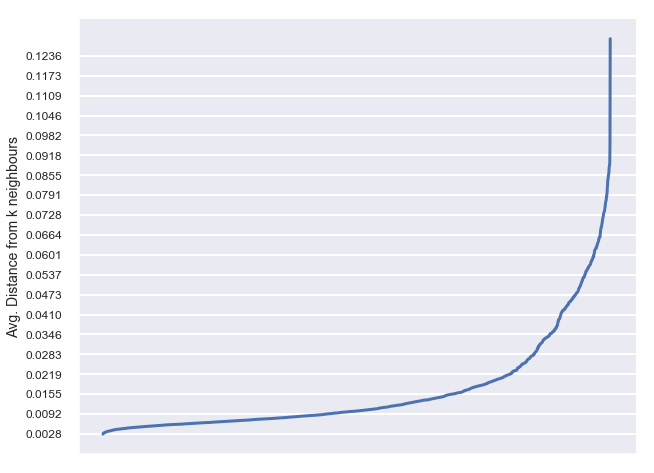

In [15]:
m=KNN_distplot(zip(dataX,dataY))

### From the above graph we can manually find the minimum distance from where this rapid increase in the avg. distance from any point to it's neighbours starts. We need to identify this min distance and pass this as eps in our plot_clusters method, which you can see below

## Point to note-
#### For an automated approach, we do need to find a mathematical way out to find a way to identify this first instance of this rapid change in the distance measure and not do that manually all the time

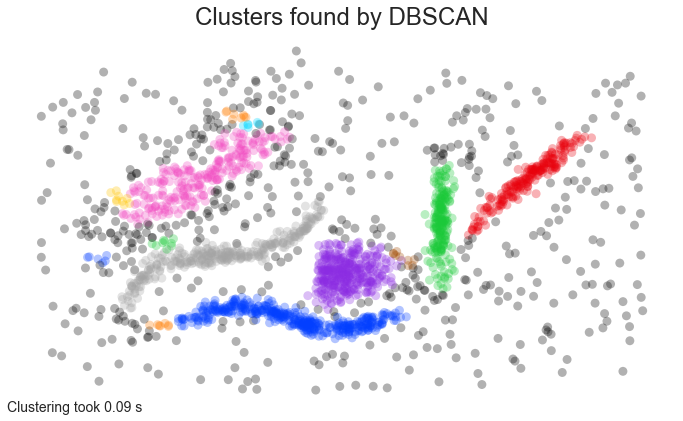

In [16]:
plot_clusters(m, cluster.DBSCAN, (), {'eps':0.02,'min_samples':neighbours});

### And as you can see, above is the working of DBSCAN and how it's easily able to find the respective and distinct clusters among all the varied values

## Let's do this analysis for another type of dataset and see how DBSCAN fares in that case

In [18]:
from sklearn.datasets import make_blobs
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,random_state=0)

In [19]:
list1= [x[0] for x in X]
list2= [x[1] for x in X]

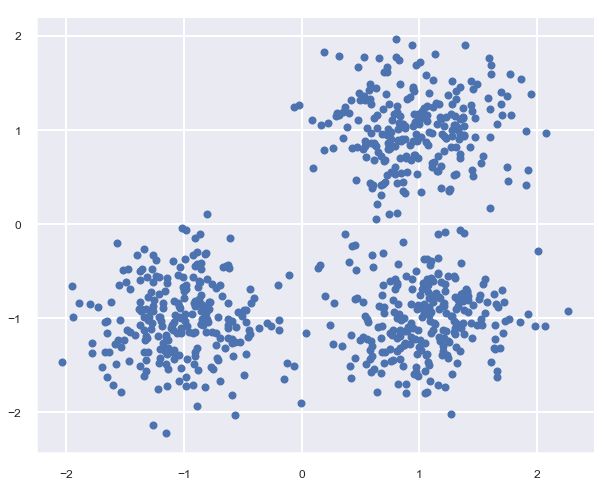

In [20]:
plt.figure(figsize=(10,8))
plt.scatter(list1,list2, marker='.')
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(True)
sns.despine()
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
frame.axis("off");

In [21]:
neighbours=6
clf = LocalOutlierFactor(n_neighbors=neighbours, contamination=0.01)

### A point to note, I have made changes to the yticks step values for the graph below in this second dataset's case(such changes are necessary at times)

### Another such change has been done to the colour pallete of the plot_clusters function above for the graph of cluster below(the earlier one was bit fade for this one

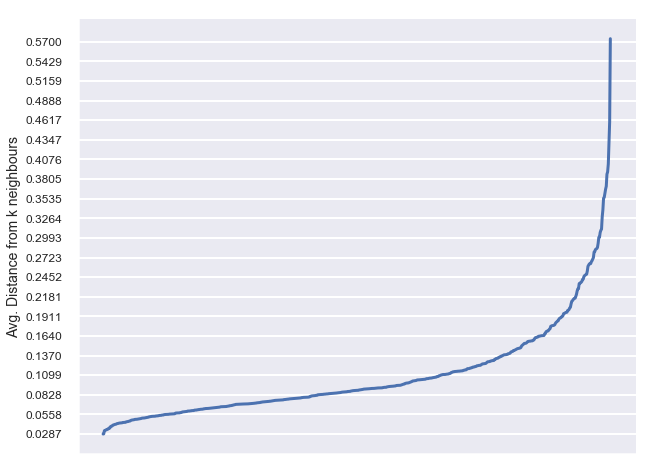

In [22]:
m=KNN_distplot(zip(list1,list2))

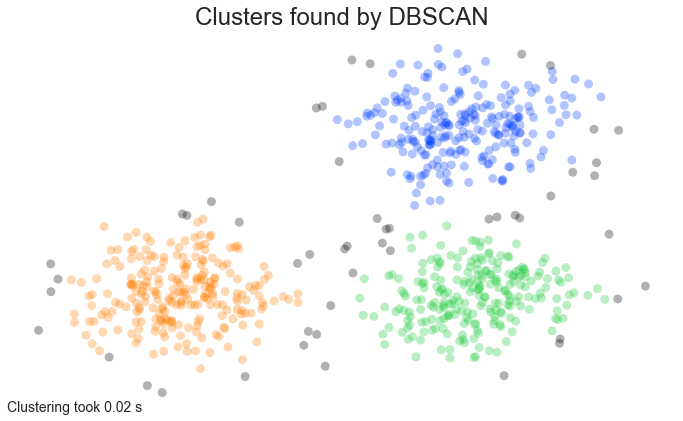

In [23]:
plot_clusters(m, cluster.DBSCAN, (), {'eps':0.25,'min_samples':10});

### The greyish dots are outliers

### So these are two example of implementation of DBSCAN